In [13]:
import os
import sys
import html
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/NLP_Assignment_2025(phase2)'
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
DATA_SAVE_PATH = os.path.join(PROJECT_PATH, 'data')

if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)
if not os.path.exists(DATA_SAVE_PATH):
    os.makedirs(DATA_SAVE_PATH)

print(f"Directory setup complete. Data and models will be saved to: {PROJECT_PATH}")

!pip install -q pyvi spacy torchtext
!python -m spacy download en_core_web_sm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory setup complete. Data and models will be saved to: /content/drive/MyDrive/NLP_Assignment_2025(phase2)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 107.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [14]:
import os
import tarfile
import sys

def download_real_data():
    data_dir = 'data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    url = "https://github.com/stefan-it/nmt-en-vi/raw/master/data/train-en-vi.tgz"
    tgz_path = os.path.join(data_dir, "train-en-vi.tgz")

    expected_vi = os.path.join(data_dir, "train.vi")
    expected_en = os.path.join(data_dir, "train.en")

    if os.path.exists(expected_vi) and os.path.exists(expected_en):
        if os.path.getsize(expected_vi) > 0:
            print("Data already exists. Skipping download.")
            return

    print("Downloading data from GitHub...")
    exit_code = os.system(f"wget -q {url} -O {tgz_path}")

    if exit_code != 0 or not os.path.exists(tgz_path) or os.path.getsize(tgz_path) < 1000:
        raise RuntimeError("ERROR: Failed to download data. Link might be broken.")

    print("Extracting data...")
    try:
        with tarfile.open(tgz_path, "r:gz") as tar:
            tar.extractall(path=data_dir)
    except Exception as e:
        raise RuntimeError(f"ERROR: Failed to extract tar file. Details: {e}")

    if not os.path.exists(expected_vi) or not os.path.exists(expected_en):
         raise RuntimeError("ERROR: Extraction finished but train.vi or train.en not found.")

    print(f"Data downloaded and extracted successfully to: {data_dir}")

try:
    download_real_data()
except RuntimeError as e:
    print(e)
    sys.exit(1)

Data already exists. Skipping download.


In [15]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_head == 0, "d_model must be divisible by n_head"
        self.d_head = d_model // n_head
        self.n_head = n_head
        self.d_model = d_model

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        Q = self.w_q(query).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        K = self.w_k(key).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        V = self.w_v(value).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.d_head)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e9)

        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(attention, V)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.fc_out(x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        _src = self.self_attn(src, src, src, src_mask)
        src = self.norm1(src + self.dropout(_src))
        _src = self.ffn(src)
        src = self.norm2(src + self.dropout(_src))
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.cross_attn = MultiHeadAttention(d_model, n_head)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg = self.self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))
        _trg = self.cross_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))
        _trg = self.ffn(trg)
        trg = self.norm3(trg + self.dropout(_trg))
        return trg

class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layer, n_head, d_ff, dropout, max_len):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        src = self.dropout(self.pos_encoding(self.embedding(src)))
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layer, n_head, d_ff, dropout, max_len):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)])
        self.fc_out = nn.Linear(d_model, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        trg = self.dropout(self.pos_encoding(self.embedding(trg)))
        for layer in self.layers:
            trg = layer(trg, enc_src, trg_mask, src_mask)
        output = self.fc_out(trg)
        return output

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, d_model=256, n_head=8, n_layer=3, d_ff=512, dropout=0.1, max_len=100, src_pad_idx=1, trg_pad_idx=1):
        super(Transformer, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.encoder = Encoder(src_vocab_size, d_model, n_layer, n_head, d_ff, dropout, max_len)
        self.decoder = Decoder(trg_vocab_size, d_model, n_layer, n_head, d_ff, dropout, max_len)

    def make_src_mask(self, src):
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=trg.device)).bool()
        return trg_pad_mask & trg_sub_mask

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        output = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import html
import os
from tqdm import tqdm

# Global tokens
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

# Hàm clean data tối ưu
def preprocess_and_save(src_path, trg_path, save_dir):
    """
    Đọc file raw, clean text và lưu vào file mới với đuôi .clean
    Trả về đường dẫn file mới.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    clean_src_path = os.path.join(save_dir, os.path.basename(src_path) + '.clean')
    clean_trg_path = os.path.join(save_dir, os.path.basename(trg_path) + '.clean')

    # Nếu file clean đã tồn tại, dùng luôn không cần làm lại
    if os.path.exists(clean_src_path) and os.path.exists(clean_trg_path):
        print(f"Found cleaned data at {save_dir}. Using cached files.")
        return clean_src_path, clean_trg_path

    print(f"Preprocessing raw data (Cleaning HTML entities)...")

    with open(src_path, 'r', encoding='utf-8') as f_src, \
         open(trg_path, 'r', encoding='utf-8') as f_trg, \
         open(clean_src_path, 'w', encoding='utf-8') as out_src, \
         open(clean_trg_path, 'w', encoding='utf-8') as out_trg:

        src_lines = f_src.readlines()
        trg_lines = f_trg.readlines()

        for src, trg in tqdm(zip(src_lines, trg_lines), total=len(src_lines)):
            # Clean text logic
            src_clean = html.unescape(src).replace('\xa0', ' ').strip()
            trg_clean = html.unescape(trg).replace('\xa0', ' ').strip()

            if src_clean and trg_clean:
                out_src.write(src_clean + '\n')
                out_trg.write(trg_clean + '\n')

    print(f"Saved cleaned data to {save_dir}")
    return clean_src_path, clean_trg_path

class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.itos = {0: "<unk>", 1: "<pad>", 2: "<sos>", 3: "<eos>"}
        self.stoi = {"<unk>": 0, "<pad>": 1, "<sos>": 2, "<eos>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self): return len(self.itos)

    def build_vocabulary(self, file_path):
        # Đọc trực tiếp từ file đã clean
        frequencies = Counter()
        idx = 4
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                for word in line.lower().strip().split():
                    frequencies[word] += 1
                    if frequencies[word] == self.freq_threshold:
                        self.stoi[word] = idx
                        self.itos[idx] = word
                        idx += 1

    def numericalize(self, text):
        return [self.stoi.get(token, self.stoi["<unk>"]) for token in text.lower().strip().split()]

class TranslationDataset(Dataset):
    def __init__(self, src_file, trg_file, src_vocab, trg_vocab, max_len=100):
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len = max_len

        print(f"Loading cleaned data from: {src_file} and {trg_file}")
        with open(src_file, 'r', encoding='utf-8') as f: self.src_data = [line.strip() for line in f.readlines()]
        with open(trg_file, 'r', encoding='utf-8') as f: self.trg_data = [line.strip() for line in f.readlines()]

        print(f"Successfully loaded {len(self.src_data)} sentence pairs.")

    def __len__(self): return len(self.src_data)

    def __getitem__(self, index):
        src_text = self.src_data[index]
        trg_text = self.trg_data[index]
        # Không clean ở đây nữa vì đã clean từ trước -> Tăng tốc độ training
        src_indices = [SOS_IDX] + self.src_vocab.numericalize(src_text) + [EOS_IDX]
        trg_indices = [SOS_IDX] + self.trg_vocab.numericalize(trg_text) + [EOS_IDX]

        if len(src_indices) > self.max_len: src_indices = src_indices[:self.max_len]
        if len(trg_indices) > self.max_len: trg_indices = trg_indices[:self.max_len]
        return torch.tensor(src_indices), torch.tensor(trg_indices)

def get_collate_fn(pad_idx):
    def collate_fn(batch):
        src_batch, trg_batch = [], []
        for src_item, trg_item in batch:
            src_batch.append(src_item)
            trg_batch.append(trg_item)
        src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=pad_idx, batch_first=True)
        trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, padding_value=pad_idx, batch_first=True)
        return src_batch, trg_batch
    return collate_fn

In [17]:
# Setup raw paths
raw_train_vi = 'data/train.vi'
raw_train_en = 'data/train.en'

# Kiểm tra file raw tồn tại
if not os.path.exists(raw_train_vi):
    if os.path.exists(os.path.join('data', 'train.vi')):
        raw_train_vi = os.path.join('data', 'train.vi')
        raw_train_en = os.path.join('data', 'train.en')

# 1. Clean data ONE TIME and Save
clean_vi_path, clean_en_path = preprocess_and_save(raw_train_vi, raw_train_en, DATA_SAVE_PATH)

print("Building Vocabulary from Cleaned Data...")
src_vocab = Vocabulary(freq_threshold=2)
trg_vocab = Vocabulary(freq_threshold=2)
src_vocab.build_vocabulary(clean_vi_path)
trg_vocab.build_vocabulary(clean_en_path)
print(f"Vocab Size: Vi={len(src_vocab)}, En={len(trg_vocab)}")

# Save vocab
torch.save(src_vocab, os.path.join(DATA_SAVE_PATH, 'src_vocab.pth'))
torch.save(trg_vocab, os.path.join(DATA_SAVE_PATH, 'trg_vocab.pth'))

# DataLoader (Load from cleaned files)
train_dataset = TranslationDataset(clean_vi_path, clean_en_path, src_vocab, trg_vocab)
train_iterator = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=get_collate_fn(PAD_IDX))

Preprocessing raw data (Cleaning HTML entities)...


100%|██████████| 133317/133317 [00:00<00:00, 221009.19it/s]


Saved cleaned data to /content/drive/MyDrive/NLP_Assignment_2025(phase2)/data
Building Vocabulary from Cleaned Data...
Vocab Size: Vi=12517, En=29345
Loading cleaned data from: /content/drive/MyDrive/NLP_Assignment_2025(phase2)/data/train.vi.clean and /content/drive/MyDrive/NLP_Assignment_2025(phase2)/data/train.en.clean
Successfully loaded 133166 sentence pairs.


In [18]:
import time
import math
import matplotlib.pyplot as plt

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):

        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))

            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)

            true_dist[:, self.padding_idx] = 0

            mask = (target == self.padding_idx) # Shape: [batch_size * seq_len]

            if mask.any():
                true_dist.masked_fill_(mask.unsqueeze(1), 0.0)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000, factor=1.0):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.factor = factor
        self.step_num = 0

    def step(self):
        self.step_num += 1
        lr = self.factor * (self.d_model ** -0.5) * min(self.step_num ** -0.5, self.step_num * (self.warmup_steps ** -1.5))
        for p in self.optimizer.param_groups:
            p['lr'] = lr

def epoch_time(start_time, end_time):
    elapsed = end_time - start_time
    return int(elapsed / 60), int(elapsed % 60)

# Hàm train
def train_one_epoch(model, iterator, optimizer, criterion, clip, device, scheduler=None):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)

        trg_input = trg[:, :-1]
        trg_output = trg[:, 1:]

        optimizer.zero_grad()
        output = model(src, trg_input)

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg_output = trg_output.contiguous().view(-1)

        loss = criterion(output, trg_output)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        if scheduler:
            scheduler.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

Training on: cuda
Trainable parameters: 22,212,001
Starting training (Phase 2 - Fixed Loss) for 10 epochs...
Epoch: 01 | Time: 5m 39s | Loss: 2.2298
New best model saved to: /content/drive/MyDrive/NLP_Assignment_2025(phase2)/checkpoints/transformer_phase2_best.pt
Epoch: 02 | Time: 5m 36s | Loss: 1.9491
New best model saved to: /content/drive/MyDrive/NLP_Assignment_2025(phase2)/checkpoints/transformer_phase2_best.pt
Epoch: 03 | Time: 5m 37s | Loss: 1.8275
New best model saved to: /content/drive/MyDrive/NLP_Assignment_2025(phase2)/checkpoints/transformer_phase2_best.pt
Epoch: 04 | Time: 5m 37s | Loss: 1.7245
New best model saved to: /content/drive/MyDrive/NLP_Assignment_2025(phase2)/checkpoints/transformer_phase2_best.pt
Epoch: 05 | Time: 5m 36s | Loss: 1.6239
New best model saved to: /content/drive/MyDrive/NLP_Assignment_2025(phase2)/checkpoints/transformer_phase2_best.pt
Epoch: 06 | Time: 5m 35s | Loss: 1.5571
New best model saved to: /content/drive/MyDrive/NLP_Assignment_2025(phase2)/

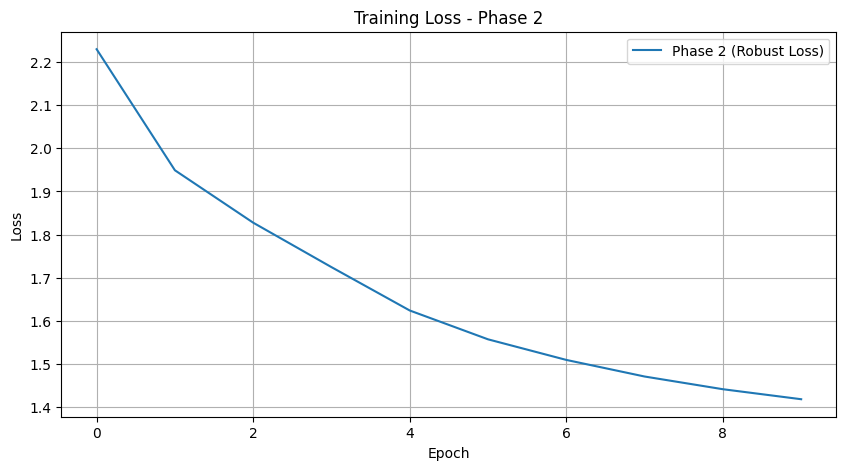

Training Phase 2 finished successfully.


In [19]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {DEVICE}")

INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
D_MODEL = 256
N_HEAD = 8
N_LAYER = 3
D_FF = 512
DROPOUT = 0.1
MAX_LEN = 150

model = Transformer(INPUT_DIM, OUTPUT_DIM, D_MODEL, N_HEAD, N_LAYER, D_FF, DROPOUT, MAX_LEN, PAD_IDX, PAD_IDX).to(DEVICE)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights)

print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)

scheduler = NoamScheduler(optimizer, d_model=D_MODEL, warmup_steps=4000)

criterion = LabelSmoothingLoss(classes=OUTPUT_DIM, padding_idx=PAD_IDX, smoothing=0.1)

N_EPOCHS = 10
CLIP = 1
train_losses = []
best_loss = float('inf')

print(f"Starting training (Phase 2 - Fixed Loss) for {N_EPOCHS} epochs...")

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train_one_epoch(model, train_iterator, optimizer, criterion, CLIP, DEVICE, scheduler)

    end_time = time.time()
    mins, secs = epoch_time(start_time, end_time)

    train_losses.append(train_loss)
    print(f'Epoch: {epoch+1:02} | Time: {mins}m {secs}s | Loss: {train_loss:.4f}')

    # Save Checkpoint
    if not os.path.exists(CHECKPOINT_PATH): os.makedirs(CHECKPOINT_PATH)
    checkpoint_name = f'transformer_phase2_epoch_{epoch+1}.pt'
    save_path = os.path.join(CHECKPOINT_PATH, checkpoint_name)
    torch.save(model.state_dict(), save_path)

    # Save Best Model
    if train_loss < best_loss:
        best_loss = train_loss
        best_save_path = os.path.join(CHECKPOINT_PATH, 'transformer_phase2_best.pt')
        torch.save(model.state_dict(), best_save_path)
        print(f"New best model saved to: {best_save_path}")

# Plot Graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Phase 2 (Robust Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss - Phase 2')
plt.legend()
plt.grid(True)
graph_path = os.path.join(PROJECT_PATH, 'loss_graph_phase2.png')
plt.savefig(graph_path)
print(f"Loss graph saved to: {graph_path}")
plt.show()

print("Training Phase 2 finished successfully.")